In [8]:
# WRITTEN BY ALAN LI
# NASA AMES LABORATORY FOR ADVANCED SENSING (LAS)
# Last edited: Nov 8, 2017

import sys
import random
import numpy as np
import cv2
import loadcoraldata_utils as coralutils
import glob, os
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from collections import Counter
import pandas as pd
import logging

import keras
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, Convolution2D, MaxPooling2D
from keras.layers.convolutional import ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras import optimizers
from keras.callbacks import Callback

%matplotlib notebook

In [2]:
def classifyback(predictions):
    return np.argmax(predictions,1)

def rescale(dataset, depth):
	dataset_norm = (dataset.astype(np.float32) - depth/2)/(depth/2)
	return dataset_norm

def load_data(Imagepath, Truthpath, truth_key = None):
	img1 = cv2.imread(Imagepath,cv2.IMREAD_UNCHANGED)
	img1_truth = cv2.imread(Truthpath,cv2.IMREAD_UNCHANGED)

	if truth_key is not None:
		item_counter = 0
		for item in truth_key:
			img1_truth[img1_truth == item ] = item_counter  # Sand
			item_counter+=1
	return img1, img1_truth.astype(np.uint8)

def load_whole_data(img1, img1_truth, image_size, depth=255, offset=0, lines=None, toremove = False):
	crop_len = int(np.floor(image_size/2))

	if lines is None:
		lines = img1.shape[0]-2*crop_len

	if offset + lines + 2*crop_len > img1.shape[0]:
		print("Too many lines specified, reverting to maximum possible")
		lines = im1.shape[0] - offset - 2*crop_len

	whole_datasets = []
	whole_labels = []
	for i in range(offset+crop_len,lines+offset+crop_len):
		for j in range(crop_len, img1.shape[1]-crop_len):
			whole_datasets.append(img1[i-crop_len:i+crop_len+1, j-crop_len:j+crop_len+1,:])
			whole_labels.append(img1_truth[i,j])

	whole_datasets = np.asarray(whole_datasets) 
	whole_labels = np.asarray(whole_labels).reshape((len(whole_labels),1))

	if toremove is not None:
		whole_datasets = np.delete(whole_datasets,toremove,-1)
	whole_dataset = rescale(whole_datasets,depth)
	return whole_dataset, whole_labels

In [3]:
offstart = 0
num_classes = 4
image_size = 25
crop_len = int(np.floor(image_size/2))
transect1_path = '../Images/Transect 1 Hi-Res.tiff'
transect1_truth_path = '../Images/Transect 1 Truth data.tif'
Transect1, Transect1_truth = load_data(transect1_path, transect1_truth_path, truth_key=[16,160,198,38])
num_lines = Transect1_truth.shape[0] - 2*crop_len
#num_lines = 250
model = load_model('./models/AlexNetLike.h5')
truth_predict = Transect1_truth[crop_len+offstart:crop_len+offstart+num_lines, crop_len:Transect1_truth.shape[1]-crop_len]

In [28]:
weightfiles = glob.glob('./models/*.hdf5')
f = open('accuracies.txt','a')

for i in range(10,40):
    whole_predict = []
    print("Currently on " + weightfiles[i])
    model.load_weights(weightfiles[i])
    for offset in range(offstart,offstart+num_lines):
        temp_dataset, temp_labelset = load_whole_data(Transect1, Transect1_truth, image_size=25, offset = offset, lines=1, toremove=3)
        temp_predict = model.predict_on_batch(temp_dataset)
        whole_predict.append(classifyback(temp_predict))
        print(str(offset+1) + '/ ' + str(num_lines) +' completed', end='\r')
    whole_predict = np.asarray(whole_predict).astype(np.uint8)
    whole_predict_map = np.copy(whole_predict.astype(np.float32))
    whole_predict_map[whole_predict_map == 0] = -1
    whole_predict_map = ((whole_predict_map+1)*255/4).astype(np.uint8)
    whole_predict_map = cv2.applyColorMap(whole_predict_map, cv2.COLORMAP_JET)
    
    cv2.imwrite(weightfiles[i].split('\\')[1].split('.')[0]+'.png',whole_predict_map)
    accuracy = 100*(whole_predict == truth_predict).astype(np.float32).sum()/(whole_predict.shape[0]*whole_predict.shape[1])
    f.write('{0} \n'.format(accuracy))
f.close()

Currently on ./models\weights_epoch00_batch00000500.hdf5
Currently on ./models\weights_epoch00_batch00000550.hdf5
Currently on ./models\weights_epoch00_batch00000600.hdf5
Currently on ./models\weights_epoch00_batch00000650.hdf5
Currently on ./models\weights_epoch00_batch00000700.hdf5
Currently on ./models\weights_epoch00_batch00000750.hdf5
Currently on ./models\weights_epoch00_batch00000800.hdf5
Currently on ./models\weights_epoch00_batch00000850.hdf5
Currently on ./models\weights_epoch00_batch00000900.hdf5
Currently on ./models\weights_epoch00_batch00000950.hdf5
Currently on ./models\weights_epoch00_batch00001000.hdf5
Currently on ./models\weights_epoch00_batch00001050.hdf5
Currently on ./models\weights_epoch00_batch00001100.hdf5
Currently on ./models\weights_epoch00_batch00001150.hdf5
Currently on ./models\weights_epoch00_batch00001200.hdf5
Currently on ./models\weights_epoch01_batch00001250.hdf5
Currently on ./models\weights_epoch01_batch00001300.hdf5
Currently on ./models\weights_e

In [13]:
#print(whole_predict[700][700])
whole_predict = np.asarray(whole_predict).astype(np.uint8)
whole_predict_map = np.copy(whole_predict.astype(np.float32))
whole_predict_map[whole_predict_map == 0] = -1
whole_predict_map = ((whole_predict_map+1)*255/4).astype(np.uint8)
whole_predict_map = cv2.applyColorMap(whole_predict_map, cv2.COLORMAP_JET)
cv2.imwrite('AlexNetLike_final.png',whole_predict_map)

truth_predict = Transect1_truth[crop_len+offstart:crop_len+offstart+num_lines, crop_len:Transect1_truth.shape[1]-crop_len]
#print(truth_predict[700][700])
accuracy = 100*(whole_predict == truth_predict).astype(np.float32).sum()/(whole_predict.shape[0]*whole_predict.shape[1])
print('Final Accuracy %.1f%%' % (accuracy))

Final Accuracy 93.8%


<IPython.core.display.Javascript object>


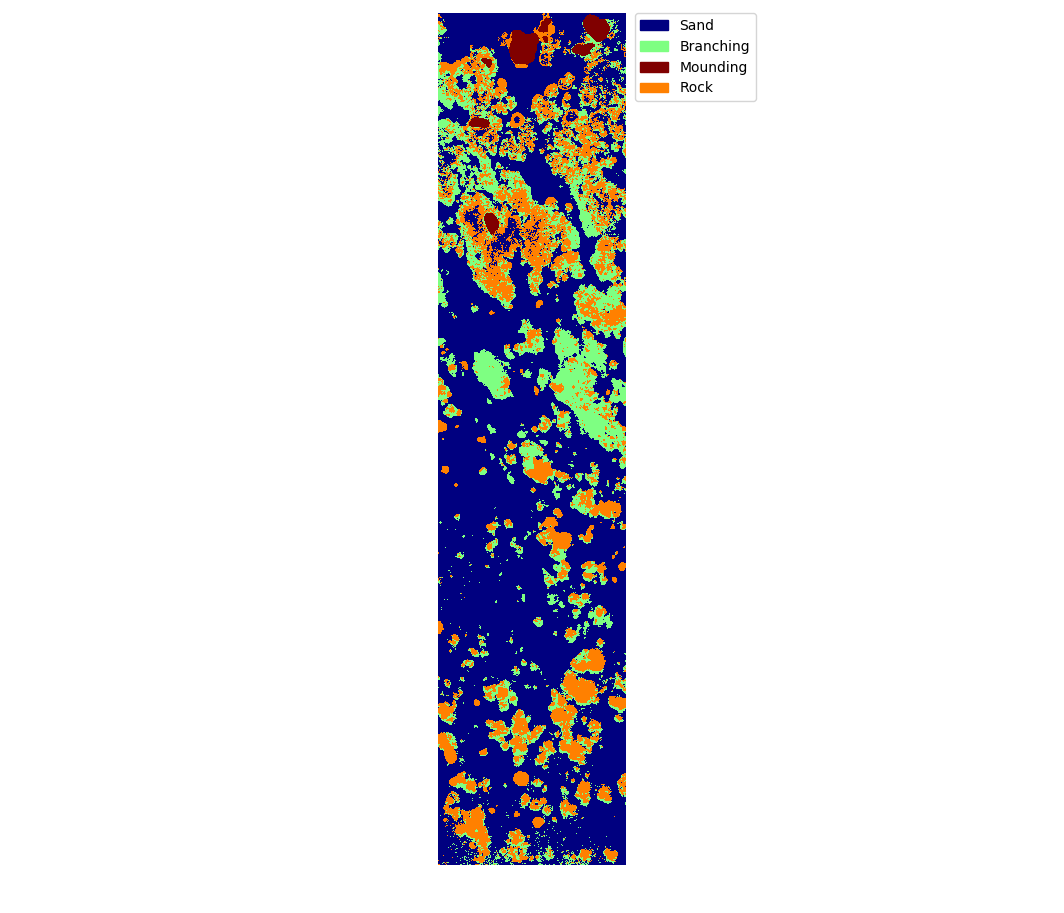

In [62]:
truth_predict = Transect1_truth[crop_len+offstart:crop_len+offstart+num_lines, crop_len:Transect1_truth.shape[1]-crop_len]
truth_predict = np.asarray(truth_predict).astype(np.float32)
truth_predict[truth_predict == 0] = -1
truth_predict = ((truth_predict+1)*255/4).astype(np.uint8)
truth_predict = cv2.applyColorMap(truth_predict, cv2.COLORMAP_JET)
cv2.imwrite('TruthMap.png',truth_predict)

b,g,r = cv2.split(truth_predict)       # get b,g,r
truth_predict = cv2.merge([r,g,b])     # switch it to rgb)
temp = np.reshape(truth_predict, (truth_predict.shape[0]*truth_predict.shape[1],3))
colors = np.unique(temp, axis=0)

fig = plt.figure()
im = plt.imshow(truth_predict)
plt.axis('off')
# values = cv2.applyColorMap((np.asarray([-1,1,2,3])*255/4).astype(np.uint8), cv2.COLORMAP_JET)
# print(values)
# b,g,r = cv2.split(values)
# values = cv2.merge([r,g,b])
#colors = [im.cmap(im.norm(value)) for value in values[0]]
#print(values[1][0])
#colors = [im.cmap(im.norm(values[i][0])) for i in range(4)]
#print(colors)
labels = ['Sand', 'Branching', 'Mounding', 'Rock']
patches = [ mpatches.Patch(color=im.norm(colors[i]), label=labels[i] ) for i in range(4) ]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
plt.tight_layout(pad=0.1, w_pad=0.1, h_pad=0.1)
plt.show()

In [32]:
values = cv2.applyColorMap((np.asarray([-1,1,2,3])*255/4).astype(np.uint8), cv2.COLORMAP_JET)
print(values[1][0])
print(im.norm(values[1][0]))
print(im.cmap(im.norm(values[1][0])))

[255 124   0]
[ 1.          0.48627451  0.        ]
[[ 0.993248  0.906157  0.143936  1.      ]
 [ 0.132444  0.552216  0.553018  1.      ]
 [ 0.267004  0.004874  0.329415  1.      ]]
